Ez a harmadik és egyben utolsó házifeladat azon Mérnökinformatikus BSc hallgatók részére akik a 2023/24/1 szemeszterben Képfeldolgozás tárgyat hallgatják.

### Bevezetés
Kézzel írott számok automatikus felismerése különböző területeket jelent előnyt. Példák: csekkek automatikus beolvasása, termékek szavatossági idejét jelző dátumok leolvasása, matematikai szoftver mely kézzel írott kifejezéseket digitalizál.
### Feladat
Osztályozást végezni képfeldolgozási módszerek és ML/AI megoldások használatával. 
 - Válassz két tetszőleges számot az MNIST adatbázisából.
 - Végezz **feature extraction**-t a választott kép-adatokon. A feature-ök a kép olyan tulajdonságai melyek megfontolásod szerint reprezentálják az adatpontokat (képeket). 
 - Hozz létre címkézett (labeled) adathalmazt és jelenítsd meg azt. 
 - Válassz egy **felügyelt tanítási módszert**, definiáld a modellt és tanítsd be a létrehozott adatbázis felhasználásával.
 - **Értékeld** a betanított modell teljesítményét valamilyen metrikával és ez alapján írd le véleményed, meglátásod, következtetésed. 
 
A feladatot összetettebbé teheted azzal, hogy több kézzel írt szám kategóriát is osztályokba sorolsz modelled segítségével. Ha érzed magadban az x-et tervezz *neurális hálózatot*, implementáld és osztályozd az egész adathalmazt.
### Adat
Az MNIST (Modified National Institute of Standards and Technology) adatbázis osztályozása klasszikus példája az **Image classification** feladat megoldásának szemléltetésére. A neurális hálózatokkal foglalkozó irodalom előszeretettel használja példának, ebből adódóan részletes információanyag elérhető az interneten. Az mnist_data könyvtárban találod az adatokat melyek betöltéséhez az *idx2numpy* csomagra van szükséged (Az adatok betöltésére példát a moving_on_with_ai_loaded.ipynb Notebook végén találsz.). 
 - Tanító képek: train-images.idx3-ubyte
 - Tanító képek címkéi: train-labels.idx1-ubyte
 - Tesztelő képek: t10k-images.idx3-ubyte
 - Tesztelő képek címkéi: t10k-labels.idx1-ubyte
 
Jó munkát és új tapasztalatokat kívánok!<br>
**Jegyzetelj, dokumentálj, indokold döntéseid!**

In [1]:
# I had a summer "internship" in which we "worked" with TensorFlow,
# I thought I might utilize my previous experience with the framework

In [2]:
import time

import numpy as np

import tensorflow as tf
from keras import layers
from tensorflow import keras

from matplotlib import pyplot as plt

In [3]:
# Hyperparameters for later use

batch_size = 32
EPOCHS = 30
classes = 10
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

In [4]:
# Loading the data

import idx2numpy
TRAIN_IMAGE_FILENAME = 'mnist_data/train-images.idx3-ubyte'
TRAIN_LABEL_FILENAME = 'mnist_data/train-labels.idx1-ubyte'
TEST_IMAGE_FILENAME = 'mnist_data/t10k-images.idx3-ubyte'
TEST_LABEL_FILENAME = 'mnist_data/t10k-labels.idx1-ubyte'

train_images = idx2numpy.convert_from_file(TRAIN_IMAGE_FILENAME)
train_labels = idx2numpy.convert_from_file(TRAIN_LABEL_FILENAME)
test_images = idx2numpy.convert_from_file(TEST_IMAGE_FILENAME)
test_labels = idx2numpy.convert_from_file(TEST_LABEL_FILENAME)

5


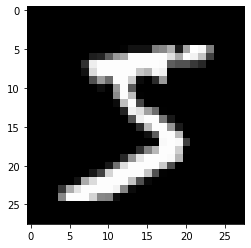

In [5]:
plt.imshow(train_images[0], 'gray')
print(train_labels[0])

In [6]:
print("Number of train images:" ,len(train_images))
print("Number of test images:" ,len(test_images))

Number of train images: 60000
Number of test images: 10000


In [7]:
input_shape = train_images[0].shape
print("The shape of images:", input_shape)

The shape of images: (28, 28)


In [8]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

# It took a lot of time to install tensorflow gpu and to get it to work with JupyterNotebook
# But it drastically improves the training time

print("Available devices: ", logical_device_names)

tf.debugging.set_log_device_placement(True)

print(tf.config.list_physical_devices('GPU'))

Available devices:  ['/device:CPU:0', '/device:GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Set the device to be used in the context of the strategy
if 'GPU' in ''.join(logical_device_names):
    strategy = tf.distribute.MirroredStrategy()
else:
  strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


The "downsize" of using a GPU is that during the training the MirroredStrategy expects the data to come in batches,
which are smaller chunks of the dataset, individually fed while training that enables parallelization, 
which in turns increases speed and reduces memory needs

It supposedly increases the generalization ability too, 
but I did not find it so when I had compared the results of batched and non-batched training

In [10]:
# Add channel dimension to the images
train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1) 

In [11]:
print(train_images[0].shape)

(28, 28, 1)


In [12]:
# It is also required to convert the data to Dataset (or something else) to be able to batch it
# Prefetch prepares the next set of data while others are being trained on to further improve speed

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (train_dataset.batch(32)).prefetch(buffer_size=32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(buffer_size=32)

In [13]:
# Define the neural network that is used for classification

with strategy.scope():
    
   model = tf.keras.models.Sequential([
       
        # Convolutional filters to extract relevant features
        # The network itself learns the best filters of the pre-defined size
        # And relu activation function because it just works
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Basically reduces the dimensionality of the array,
        # for compatibility with the dense layer
        layers.Flatten(),
        
        # I found that a single layer with only 64 neuron give great accuracy without much overfitting
        layers.Dense(64, activation='relu'),
           
        # Dropout disables some neurons during training so the model doesn't rely too much on it
        # Greatly helps with overfitting
        layers.Dropout(0.2),
    
        # The final layer, which will have the output
        # Softmax returns a probability for each of the classes
        layers.Dense(classes, activation="softmax")
    ])

In [14]:
# With callbacks we can do some useful things while training

callbacks = [
    #  This callback saves the model every 100 batches.
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_dir/saved-model.hdf5",
        save_freq=100,
        monitor='accuracy',
        mode='max',
        save_best_only=True,
        verbose=0,
    ), 
    # Stop training when `val_accuracy` is no longer improving
    keras.callbacks.EarlyStopping(
        
        monitor="val_accuracy",
        min_delta=1e-5,
        patience=2,
        verbose=1,
    )
]

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [16]:
# Compiling the model

with strategy.scope():
    
    model.compile(
        
        # Updating the weights using adam, which uses adaptive learning rate scheduling
        optimizer=tf.keras.optimizers.Adam(), 
        
        # The loss function is used to quantify how badly the model performs (the difference between the output and the actual value)
        # Sparse Categorical CrossEntropy is used for integer labels
        # It penalises loss logarithmically
        loss='sparse_categorical_crossentropy',

        # List of metrics to monitor
        # Accuracy represents the ratio of correctly predicted instances to the total
        metrics=['accuracy']
    )


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [17]:
# Training the neural network
# The batch size is default 32

start = time.perf_counter()

with strategy.scope():
    history = model.fit(
        # Input data: inputs, labels combined 
        train_dataset,
        # The data on which to evaluate the accuracy of the training
        validation_data=test_dataset,
        # The number of how many times we want to iterate over the entire dataset
        epochs=EPOCHS, 
        verbose=2, 
        # callbacks=callbacks
    )

print(f"Training time: {time.perf_counter() - start} seconds")

Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
1875/1875 - 15s - loss: 0.3008 - accuracy: 0.9236 - val_loss: 0.0825 - val_accuracy: 0.9754
Epoch 2/30
1875/1875 - 8s - loss: 0.0891 - accuracy: 0.97

In [29]:
print(history.history)

{'loss': [0.30076509714126587, 0.08906883001327515, 0.06601231545209885, 0.0536457896232605, 0.04666978493332863, 0.04398130998015404, 0.03719150274991989, 0.03675137087702751, 0.034648358821868896, 0.027841461822390556, 0.03066028654575348, 0.028423752635717392, 0.024547487497329712, 0.027334824204444885, 0.023928890004754066, 0.02478807419538498, 0.023514483124017715, 0.02515995502471924, 0.02266283519566059, 0.024614974856376648, 0.02728206105530262, 0.024098116904497147, 0.020905975252389908, 0.025634363293647766, 0.026366718113422394, 0.01657484658062458, 0.026979366317391396, 0.02533213049173355, 0.029561199247837067, 0.01829613372683525], 'accuracy': [0.9236000180244446, 0.9749666452407837, 0.981249988079071, 0.9843166470527649, 0.9867333173751831, 0.9874833226203918, 0.9890499711036682, 0.9896833300590515, 0.9901333451271057, 0.9920333623886108, 0.9921333193778992, 0.9920499920845032, 0.9929166436195374, 0.992983341217041, 0.9932833313941956, 0.9936833381652832, 0.9939666390419

In [18]:
# The loss and accuracy on the test data:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')
print(f'\nTest loss: {test_loss}')

313/313 - 1s - loss: 0.1325 - accuracy: 0.9890

Test accuracy: 0.9890000224113464

Test loss: 0.13246260583400726


In [19]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# We can see what probability does the model assign to each of the labels

print("Generate predictions for 3 samples")
predictions = model.predict(test_images[:3])

# for prediction in predictions:
#     for percent in prediction:
#         print(round(percent * 100, 1), end="    ")
#     print()

predictions

Generate predictions for 3 samples


array([[0.0000000e+00, 0.0000000e+00, 2.4801976e-27, 0.0000000e+00,
        5.6388039e-29, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 2.6100474e-25],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.8512269e-36, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [20]:
# Better visualize the predictions
for images, labels in test_dataset.take(1):  # Take a batch from the test dataset
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    for i in range(len(labels)):
        print(f"True Label: {labels[i]}, Predicted Label: {predicted_labels[i]}")

True Label: 7, Predicted Label: 7
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 0, Predicted Label: 0
True Label: 4, Predicted Label: 4
True Label: 1, Predicted Label: 1
True Label: 4, Predicted Label: 4
True Label: 9, Predicted Label: 9
True Label: 5, Predicted Label: 5
True Label: 9, Predicted Label: 9
True Label: 0, Predicted Label: 0
True Label: 6, Predicted Label: 6
True Label: 9, Predicted Label: 9
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 1
True Label: 5, Predicted Label: 5
True Label: 9, Predicted Label: 9
True Label: 7, Predicted Label: 7
True Label: 3, Predicted Label: 3
True Label: 4, Predicted Label: 4
True Label: 9, Predicted Label: 9
True Label: 6, Predicted Label: 6
True Label: 6, Predicted Label: 6
True Label: 5, Predicted Label: 5
True Label: 4, Predicted Label: 4
True Label: 0, Predicted Label: 0
True Label: 7, Predicted Label: 7
True Label: 4, Predicted Label: 4
True Label: 0, Predicted Label: 0
True Label: 1,

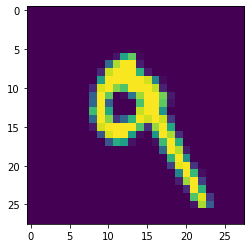

In [21]:
plt.imshow(tf.squeeze( test_images[7]))

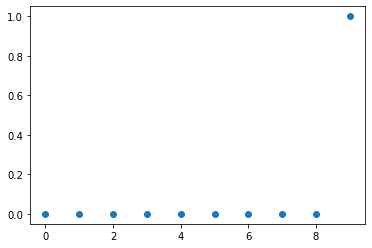

In [22]:
plt.scatter(range(10), predictions[7])

Surprisingly, he model learns the data at great accuracy very quickly.
And with little overfitting.
But we can see that if the training continues for longer the validation accuracy decreases as the model increasingly overfits.


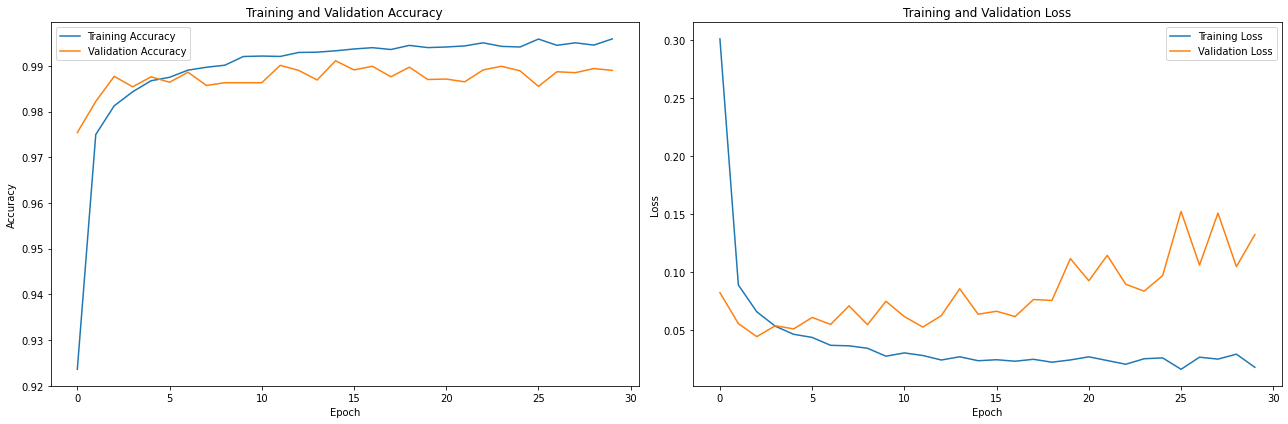

In [23]:
# Plotting training and validation accuracy values
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Confusion matrix on the test data:

y_true = []
y_pred = []

for images, labels in test_dataset:
    for label in labels:
        y_true.append(tf.cast(label, dtype=tf.int32).numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

correct =  0
incorrect = 0

for true_label, predicted_label in zip(y_true, y_pred):
    if true_label == predicted_label:
        correct += 1
    else:
        incorrect +=1
        
print("Correct: ", correct)
print("Incorrect: ", incorrect)

Correct:  9890
Incorrect:  110


In [25]:
from sklearn.metrics import confusion_matrix

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 973    1    0    0    0    0    2    2    2    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   2    2 1020    1    2    0    0    5    0    0]
 [   0    0    1  992    0   10    0    3    2    2]
 [   0    0    0    0  966    0    1    1    0   14]
 [   3    0    0    2    0  884    1    1    0    1]
 [   2    5    0    0    0    3  947    0    1    0]
 [   0    4    3    0    1    0    0 1018    1    1]
 [   1    0    1    0    1    2    2    1  963    3]
 [   1    2    0    0    5    3    0    5    0  993]]


At a previous training it was easily observable that the model sometimes confused 9 and 5,
And now 8 and 3 

In [26]:
from sklearn.metrics import classification_report

# Some deeper metrics:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


In [27]:
# I thought about doing data augmentation to improve the accuracy, 
# but with 99% it wouldn't lead to any significant improvement

with strategy.scope():

    data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1)
        ]
    )